
# An Introduction to Flow Matching

This notebook provides a hands-on introduction to **Flow Matching**, a modern and efficient method for training continuous normalizing flows and generative models. We'll build a simple model from scratch to transform one 2D distribution into another.

The primary goal is to understand the core insight of Flow Matching: **how a neural network can learn a complex, global velocity field by only looking at simple, straight-line paths between randomly paired data points.**



## The Core Idea: From Simple Paths to Complex Flows

Generative modeling can be viewed as learning a transformation that morphs a simple distribution, $p_0$ (like a Gaussian), into a complex target data distribution, $p_1$. Continuous Normalizing Flows (CNFs) model this transformation as a smooth evolution over a continuous time variable $t \in [0,1]$.

This evolution is defined by an Ordinary Differential Equation (ODE):
$$
\frac{d\mathbf{x}_t}{dt} = v_t(\mathbf{x}_t),
$$
where $\mathbf{x}_t$ is the position of a particle at time $t$, and $v_t(\mathbf{x}_t)$ is a time-varying **vector field** that tells the particle where to go next. The challenge is to find this vector field.

### The Problem with Learning the Vector Field

Directly learning the true vector field $v_t(\mathbf{x})$ is hard because it's defined on the *marginal* probability path $p_t(\mathbf{x})$, which we don't know how to compute easily.

### The Flow Matching Solution: The Power of Expectation

Flow Matching provides an elegant solution. Instead of thinking about the complex, unknown path of the overall distribution, we define a much simpler **conditional path**. Given a starting point $\mathbf{x}_0 \sim p_0$ and an ending point $\mathbf{x}_1 \sim p_1$, we can define a straight-line path between them:
$$
p_t(\mathbf{x}\mid \mathbf{x}_0,\mathbf{x}_1).
$$

The point on this path at time $t$ is simply a linear interpolation:
$$
\mathbf{x}_t = (1-t)\,\mathbf{x}_0 + t\,\mathbf{x}_1.
$$

The "velocity" along this simple, straight path is constant and trivial to calculate: it's just the vector pointing from $\mathbf{x}_0$ to $\mathbf{x}_1$,
$$
\mathbf{u}_t(\mathbf{x}\mid \mathbf{x}_0,\mathbf{x}_1) = \mathbf{x}_1 - \mathbf{x}_0.
$$

Here's the key insight from Flow Matching (Lipman et al., 2022): the complex, unknown marginal vector field $v_t(\mathbf{x})$ is the **expected value of these simple conditional velocity vectors**, conditioned on being at point $\mathbf{x}$ at time $t$,
$$
v_t(\mathbf{x})=\mathbb{E}_{p(\mathbf{x}_0,\mathbf{x}_1 \mid \mathbf{x}_t=\mathbf{x})}\big[\mathbf{x}_1-\mathbf{x}_0\big].
$$

We can train a neural network $v_{\theta}(\mathbf{x},t)$ to learn this expected value by minimizing
$$
\mathcal{L}_{\mathrm{FM}}
= \mathbb{E}_{t,\mathbf{x}_0,\mathbf{x}_1}\!\left[
\left\|\, v_{\theta}\!\big((1-t)\mathbf{x}_0 + t\mathbf{x}_1,\, t\big) - (\mathbf{x}_1 - \mathbf{x}_0) \right\|^2
\right].
$$

**Training procedure (conceptual):**
1. Sample $t \sim \mathrm{Uniform}(0,1)$.
2. Randomly pair $\mathbf{x}_0 \sim p_0$ with $\mathbf{x}_1 \sim p_1$.
3. Form $\mathbf{x}_t=(1-t)\mathbf{x}_0 + t\mathbf{x}_1$.
4. Predict $v_{\theta}(\mathbf{x}_t,t)$.
5. Match it to the target velocity $\mathbf{x}_1-\mathbf{x}_0$.


## 1. Setup and Imports

In [15]:

import torch
import math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgba
import warnings
from IPython.display import HTML

# --- Basic Setup ---
warnings.filterwarnings("ignore")
# Check for available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda



## 2. Defining Data Distributions

We need a starting distribution $p_0$ and a target distribution $p_1$.  
- **$p_0$ (Initial):** A simple, single Gaussian distribution.  
- **$p_1$ (Target):** A mixture of two Gaussians.


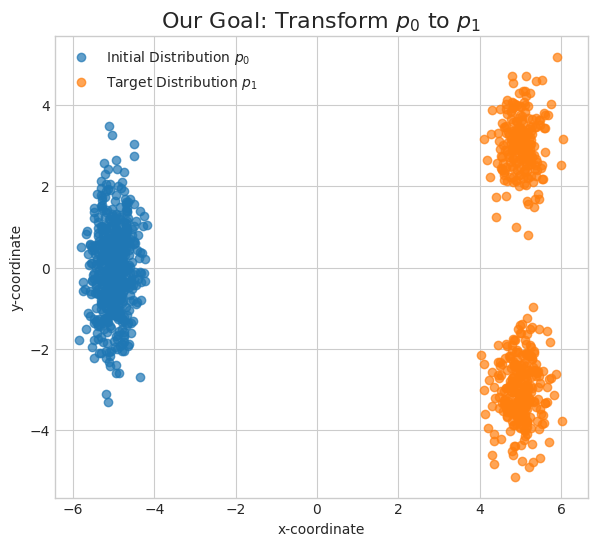

In [16]:

# --- 1. Define Data Distributions ---
# Initial distribution p₀ (a single Gaussian)
p0_mean = torch.tensor([-5.0, 0.0], device=device)
p0_cov = torch.tensor([[0.1, 0.0], [0.0, 1.2]], device=device)

# Target distribution p₁ (a mixture of two Gaussians)
p1_means = [
    torch.tensor([5.0, 3.0], device=device),
    torch.tensor([5.0, -3.0], device=device)
]
p1_covs = [
    torch.tensor([[0.1, 0.0], [0.0, 0.5]], device=device),
    torch.tensor([[0.1, 0.0], [0.0, 0.5]], device=device)
]
p1_weights = torch.tensor([0.5, 0.5], device=device)

def sample_p0(n_samples):
    # Sample from the initial distribution p₀.
    dist = torch.distributions.MultivariateNormal(p0_mean, p0_cov)
    return dist.sample((n_samples,))

def sample_p1(n_samples):
    # Sample from the target mixture distribution p₁.
    indices = torch.multinomial(p1_weights, n_samples, replacement=True)
    samples = torch.zeros(n_samples, 2, device=device)
    for i, (mean, cov) in enumerate(zip(p1_means, p1_covs)):
        mask = indices == i
        n_choice = mask.sum()
        if n_choice > 0:
            dist = torch.distributions.MultivariateNormal(mean, cov)
            samples[mask] = dist.sample((n_choice,))
    return samples

# Let's visualize our starting and ending points
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
x0_samples = sample_p0(500).cpu().numpy()
x1_samples = sample_p1(500).cpu().numpy()
ax.scatter(x0_samples[:, 0], x0_samples[:, 1], alpha=0.7, label=r'Initial Distribution $p_0$')
ax.scatter(x1_samples[:, 0], x1_samples[:, 1], alpha=0.7, label=r'Target Distribution $p_1$')
ax.set_title('Our Goal: Transform $p_0$ to $p_1$', fontsize=16)
ax.set_xlabel('x-coordinate')
ax.set_ylabel('y-coordinate')
ax.legend()
ax.set_aspect('equal', adjustable='box')
plt.show()



## 3. The Neural Network Model

Our vector field approximator, $v_{\theta}(\mathbf{x}, t)$, is a simple MLP. It takes a 2D spatial coordinate $\mathbf{x}$ and a scalar time $t$ and outputs a 2D velocity.


In [17]:

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.ff(x))

class VectorFieldNet(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t
        x = self.blocks(x)
        x = self.out_projection(x)
        return x



## 4. The Training Loop

Each batch implements the Flow Matching objective:
1) sample random pairs $(\mathbf{x}_0,\mathbf{x}_1)$,  
2) sample $t \sim \mathcal{U}(0,1)$,  
3) form $\mathbf{x}_t=(1-t)\mathbf{x}_0 + t\mathbf{x}_1$,  
4) predict $v_{\theta}(\mathbf{x}_t,t)$,  
5) match to $\mathbf{x}_1-\mathbf{x}_0$ with an $\ell_2$ loss.


In [18]:

def train_flow_matching(model, epochs=5000, batch_size=2048, lr=1e-4):
    # Train the Flow Matching model.
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    print("Starting training...")

    for epoch in range(epochs):
        optimizer.zero_grad()

        # 1. Randomly sample a batch from the initial and target distributions.
        x0 = sample_p0(batch_size)
        x1 = sample_p1(batch_size)
        
        # 2. Randomly sample a time t for each pair in the batch.
        t = torch.rand(batch_size, device=device)

        # 3. Construct the interpolated points x_t along the straight paths.
        x_t = (1 - t.unsqueeze(1)) * x0 + t.unsqueeze(1) * x1
        
        # 4. Define the target velocity u_t, which is just the vector from x0 to x1.
        u_t = x1 - x0

        # Predict the velocity at (x_t, t) using our network.
        v_pred = model(x_t, t)

        # 5. Compute the Mean Squared Error loss between the prediction and the target.
        loss = loss_fn(v_pred, u_t)
        
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    print("Training finished!")
    return model

# --- Instantiate and Train the Model ---
model = VectorFieldNet().to(device)
model = train_flow_matching(model)


Starting training...
Epoch [500/5000], Loss: 2.441501
Epoch [1000/5000], Loss: 2.206495
Epoch [1500/5000], Loss: 2.223369
Epoch [2000/5000], Loss: 2.193009
Epoch [2500/5000], Loss: 2.181177
Epoch [3000/5000], Loss: 2.315148
Epoch [3500/5000], Loss: 2.429219
Epoch [4000/5000], Loss: 2.399819
Epoch [4500/5000], Loss: 2.415552
Epoch [5000/5000], Loss: 2.297680
Training finished!



## 5. Generating Samples with an ODE Solver

With the trained $v_{\theta}(\mathbf{x},t)$, generate samples by integrating
$$
\mathbf{x}_1 = \mathbf{x}_0 + \int_{0}^{1} v_{\theta}(\mathbf{x}_t,t)\,dt.
$$
We use Heun's method (a predictor–corrector scheme).


In [19]:

def solve_ode_heun(model, x0, num_steps):
    # Solve the ODE dx/dt = v(x,t) using Heun's method.
    model.eval()
    trajectory = [x0.clone()]
    x = x0.clone()
    dt = 1.0 / num_steps

    with torch.no_grad():
        for i in range(num_steps):
            t = torch.full((x.size(0),), i * dt, device=device)
            # Predict velocity at the current point (predictor step)
            v_pred = model(x, t)
            x_tilde = x + dt * v_pred
            
            # Predict velocity at the predicted next point (corrector step)
            t_next = torch.full((x.size(0),), (i + 1) * dt, device=device)
            v_tilde = model(x_tilde, t_next)
            
            # Average the velocities for a more accurate step
            x = x + 0.5 * dt * (v_pred + v_tilde)
            trajectory.append(x.clone())

    return torch.stack(trajectory).cpu().numpy()



## 6. Visualization: Training Pairs & Sampled Trajectories

We show: (i) the random line-pairings used in training, and (ii) trajectories obtained by integrating the learned ODE with different step counts.


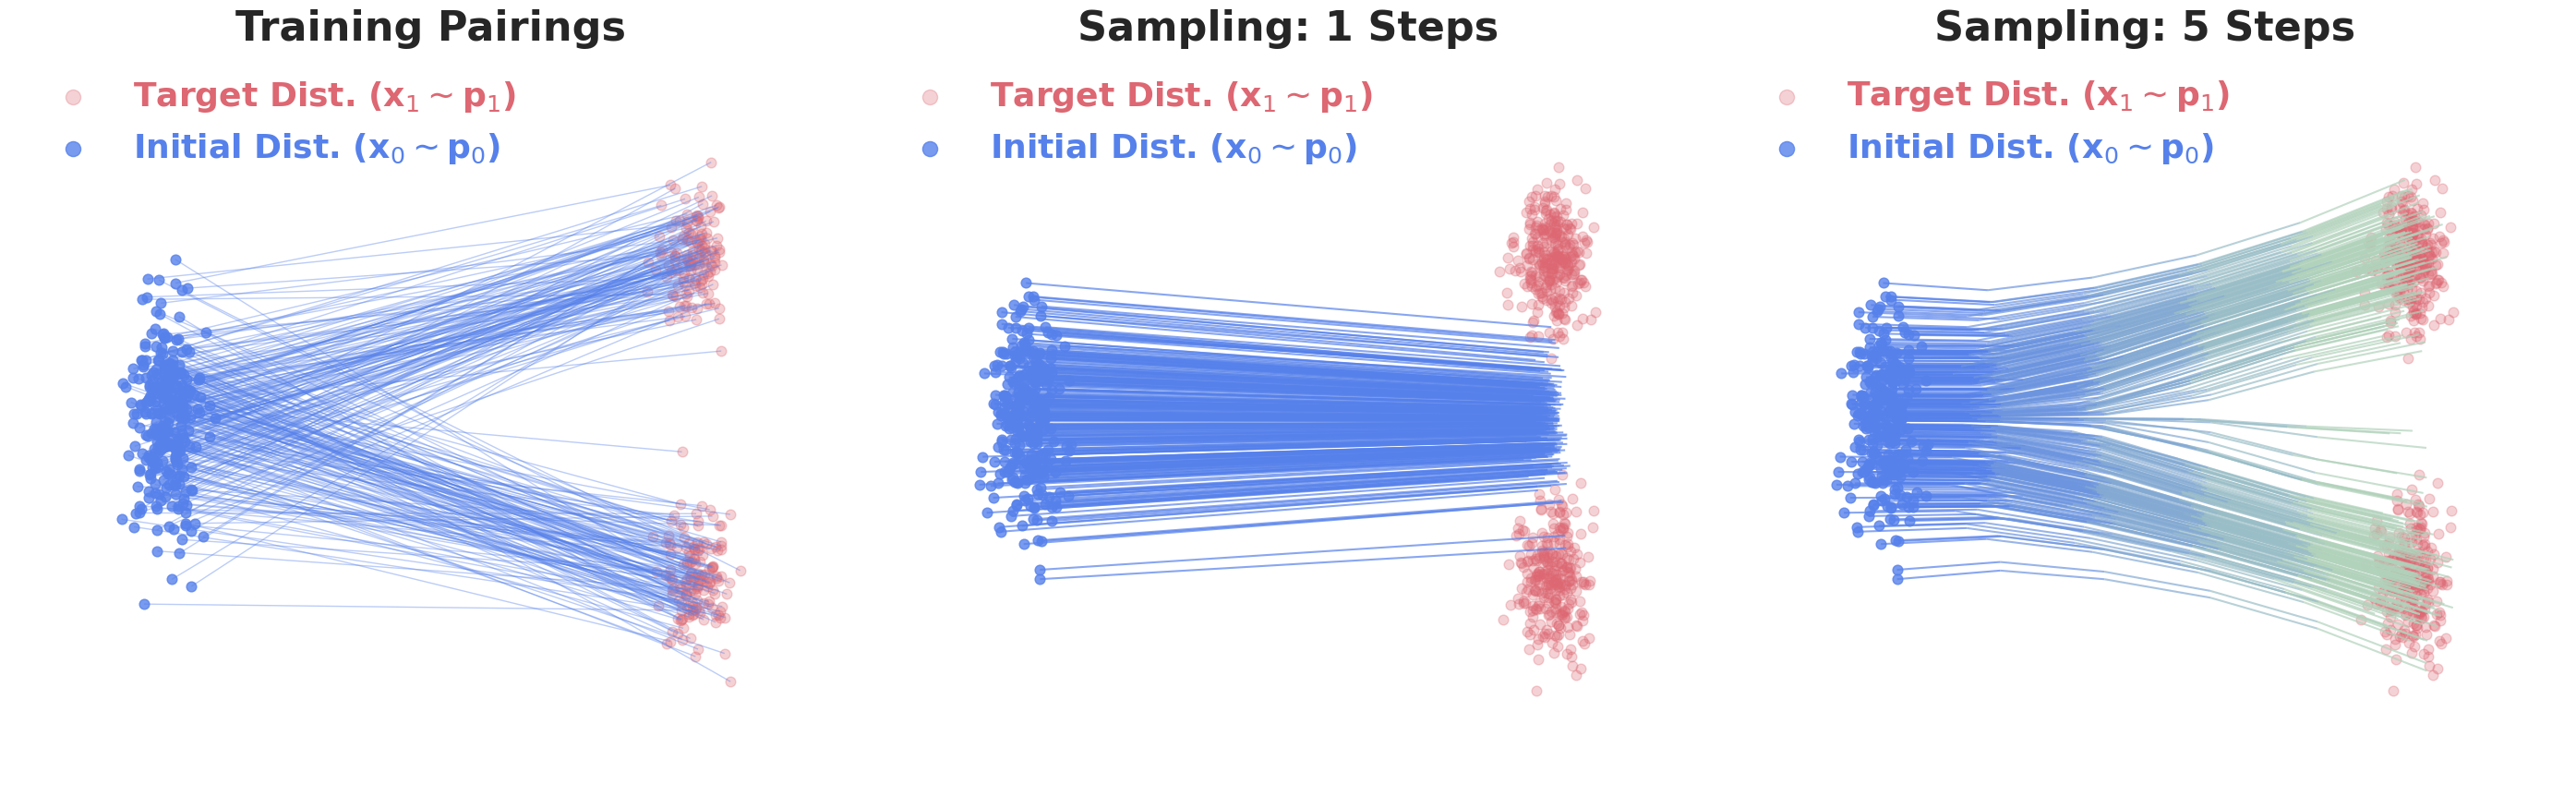

In [20]:

# --- Visualization Functions ---

def plot_training_pairs(ax, n_samples):
    # Plots the first subplot showing the random pairing of x0 and x1 during training.
    color_p0 = '#5681EB'
    color_p1 = '#DD6772'

    ax.set_facecolor('white')
    ax.grid(False)
    ax.axis('off')

    x0_samples = sample_p0(n_samples).cpu().numpy()
    x1_samples = sample_p1(n_samples).cpu().numpy()

    ax.scatter(x1_samples[:, 0], x1_samples[:, 1],
               color=color_p1, alpha=0.3, s=60, label=r'Target Dist. ($\mathbf{x}_1\sim\mathbf{p}_1$)')
    ax.scatter(x0_samples[:, 0], x0_samples[:, 1],
               color=color_p0, alpha=0.8, s=60, label=r'Initial Dist. ($\mathbf{x}_0\sim\mathbf{p}_0$)')

    lines = np.array(list(zip(x0_samples, x1_samples)))
    lc = LineCollection(lines, colors=color_p0, linewidths=1.0, alpha=0.4)
    ax.add_collection(lc)

    ax.set_title('Training Pairings', fontsize=32, fontweight='bold')
    ax.legend(
        loc='upper left',
        prop={'weight': 'bold', 'size': 26},
        labelcolor=[color_p1, color_p0],
        markerscale=1.5,
        frameon=False
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-7, 7)

def create_subplot(ax, trajectories, x0_samples, x1_samples, num_steps):
    # Draws a single subplot for the sampling process.
    color_p0 = '#5681EB'
    color_x0 = '#5681EB'
    color_p1 = '#DD6772'
    color_x1 = '#B1D2BB'

    ax.set_facecolor('white')
    ax.grid(False)
    ax.axis('off')

    ax.scatter(x1_samples[:, 0], x1_samples[:, 1],
               color=color_p1, alpha=0.3, s=60, label=r'Target Dist. ($\mathbf{x}_1\sim\mathbf{p}_1$)')
    ax.scatter(x0_samples[:, 0], x0_samples[:, 1],
               color=color_p0, alpha=0.8, s=60, label=r'Initial Dist. ($\mathbf{x}_0\sim\mathbf{p}_0$)')

    lines = []
    colors = []
    start_rgba = np.array(to_rgba(color_x0))
    end_rgba = np.array(to_rgba(color_x1))
    for i in range(trajectories.shape[1]):
        points = trajectories[:, i, :]
        segments = np.array([points[:-1], points[1:]]).transpose(1, 0, 2)
        lines.extend(segments)
        t_fractions = np.linspace(0, 1, num_steps)
        segment_colors = (1 - t_fractions[:, np.newaxis]) * start_rgba + t_fractions[:, np.newaxis] * end_rgba
        colors.extend(segment_colors)

    lc = LineCollection(lines, colors=colors, linewidths=1.5, alpha=0.7)
    ax.add_collection(lc)
    ax.set_title(f'Sampling: {num_steps} Steps', fontsize=32, fontweight='bold')
    ax.legend(
        loc='upper left',
        prop={'weight': 'bold', 'size': 26},
        labelcolor=[color_p1, color_p0],
        markerscale=1.5,
        frameon=False
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-7, 7)

def visualize_trajectories(model, n_samples=300):
    # Creates a figure with three subplots.
    steps_to_plot = [1, 5]
    fig, axes = plt.subplots(1, 3, figsize=(28, 9))
    fig.patch.set_facecolor('white')

    # --- Subplot 1: Show training pairs ---
    plot_training_pairs(axes[0], n_samples)

    # --- Subplots 2 & 3: Show sampling process ---
    x0_samples_ode = sample_p0(n_samples).cpu().numpy()
    x1_samples_display = sample_p1(n_samples * 2).cpu().numpy()
    x0_tensor = torch.tensor(x0_samples_ode, device=device)

    for ax, num_steps in zip(axes[1:], steps_to_plot):
        trajectories = solve_ode_heun(model, x0_tensor, num_steps)
        create_subplot(ax, trajectories, x0_samples_ode, x1_samples_display, num_steps)

    plt.tight_layout()
    plt.show()

# --- Run the visualization ---
visualize_trajectories(model)



## 7. Animation: Watch the Flow in Action!

We animate three phases: (i) dynamic random pairings, (ii) vector-field arrows along trajectories, and (iii) sample points moving along the same paths.


In [ ]:

# --- Animation Functions ---

def animate_flow_matching_with_pairing(model, n_samples=100, num_flow_frames=60):
    """
    Creates a three-stage animation.

    Phase 1: Dynamically shows the random pairing between p0 and p1 samples.
    Phase 2: Arrows travel along trajectories, drawing trails.
    Phase 3: Samples travel along the same trajectories.

    Args:
        model (nn.Module): The trained Flow Matching model.
        n_samples (int): The number of sample points to animate.
        num_flow_frames (int): The number of frames for a single flow (phases 2 & 3).
    """
    print("Generating three-stage animation with pairing visualization...")

    # --- 1. Pre-computation Phase ---
    # Sample data points for all phases
    x0_samples_torch = sample_p0(n_samples)
    x0_samples_np = x0_samples_torch.cpu().numpy()
    x1_samples_np = sample_p1(n_samples).cpu().numpy()
    x1_samples_display = sample_p1(n_samples * 2).cpu().numpy() # For background display

    # Pre-compute trajectories and velocities for the flow part (Phases 2 & 3)
    trajectories = solve_ode_heun(model, x0_samples_torch, num_steps=num_flow_frames - 1)
    velocities = np.zeros_like(trajectories)
    model.eval()
    with torch.no_grad():
        for i in range(num_flow_frames):
            t = torch.full((n_samples,), i / (num_flow_frames - 1), device=device)
            positions_torch = torch.from_numpy(trajectories[i]).to(device)
            velocities[i] = model(positions_torch, t).cpu().numpy()

    # --- 2. Animation Setup ---
    # Define frame counts for each phase
    n_pairing_rounds = 2
    pairing_frames_per_round = n_samples
    total_pairing_frames = n_pairing_rounds * pairing_frames_per_round
    total_flow_frames = 2 * num_flow_frames
    total_animation_frames = total_pairing_frames + total_flow_frames

    # Pre-generate random pairings for reproducibility within the animation
    pairing_indices = [np.random.permutation(n_samples) for _ in range(n_pairing_rounds)]

    # --- 3. Matplotlib Figure Setup ---
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    color_p0 = '#5681EB'
    color_p1 = '#DD6772'
    color_line = '#666666'
    color_trail = '#B1D2BB'
    color_arrow = '#E03516'

    def update(frame):
        ax.clear()
        ax.set_facecolor('white')
        ax.grid(False)
        ax.axis('off')
        ax.set_xlim(-8, 8)
        ax.set_ylim(-7, 7)
        ax.set_aspect('equal', adjustable='box')

        # --- STAGE 1: PAIRING ANIMATION ---
        if frame < total_pairing_frames:
            round_num = frame // pairing_frames_per_round
            line_idx_in_round = frame % pairing_frames_per_round

            ax.set_title(f'Training Pairings (Epoch {round_num + 1}/{n_pairing_rounds})',
                         fontsize=20, fontweight='bold')

            # Draw the base distributions
            ax.scatter(x1_samples_np[:, 0], x1_samples_np[:, 1],
                       color=color_p1, alpha=0.3, s=60)
            ax.scatter(x0_samples_np[:, 0], x0_samples_np[:, 1],
                       color=color_p0, alpha=0.8, s=60)

            # Collect all lines that should be drawn in this frame
            lines_to_draw = []
            # Draw all lines from previous full rounds
            for r in range(round_num):
                indices = pairing_indices[r]
                round_lines = np.stack((x0_samples_np[indices], x1_samples_np), axis=1)
                lines_to_draw.extend(list(round_lines))

            # Draw lines for the current, partially completed round
            current_round_indices = pairing_indices[round_num]
            current_round_lines = np.stack((x0_samples_np[current_round_indices[:line_idx_in_round+1]],
                                            x1_samples_np[:line_idx_in_round+1]), axis=1)
            lines_to_draw.extend(list(current_round_lines))

            if lines_to_draw:
                lc = LineCollection(lines_to_draw, colors=color_line, linewidths=0.8, alpha=0.5)
                ax.add_collection(lc)

        # --- STAGES 2 & 3: FLOW ANIMATION ---
        else:
            flow_frame = frame - total_pairing_frames
            # Background target distribution for context
            ax.scatter(x1_samples_display[:, 0], x1_samples_display[:, 1],
                       color=color_p1, alpha=0.1, s=60)

            # --- STAGE 2: VECTOR FIELD FLOW ---
            if flow_frame < num_flow_frames:
                flow_idx = flow_frame
                ax.scatter(x0_samples_np[:, 0], x0_samples_np[:, 1],
                           color=color_p0, alpha=0.5, s=60)

                # Draw trails efficiently
                if flow_idx > 0:
                    paths_so_far = trajectories[0:flow_idx + 1]
                    points_start = paths_so_far[:-1]
                    points_end = paths_so_far[1:]
                    segments = np.stack((points_start, points_end), axis=2)
                    segments = segments.transpose(1, 0, 2, 3).reshape(-1, 2, 2)
                    trail_collection = LineCollection(segments, colors=color_trail, linewidths=1.5, alpha=0.4)
                    ax.add_collection(trail_collection)

                # Draw moving arrows
                current_positions = trajectories[flow_idx]
                current_velocities = velocities[flow_idx]
                scale_factor = 40
                ax.quiver(current_positions[:, 0], current_positions[:, 1],
                          current_velocities[:, 0], current_velocities[:, 1],
                          color=color_arrow, angles='xy', scale_units='xy', scale=scale_factor,
                          headwidth=4, headlength=5, width=0.005)

                current_time = flow_idx / (num_flow_frames - 1)
                ax.set_title(f'Vector Field Flow\nTime $t={current_time:.2f}$',
                             fontsize=20, fontweight='bold')

            # --- STAGE 3: SAMPLE POINTS FLOW ---
            else:
                flow_idx = flow_frame - num_flow_frames
                current_positions = trajectories[flow_idx]
                ax.scatter(current_positions[:, 0], current_positions[:, 1],
                           color=color_p0, alpha=0.8, s=60)

                current_time = flow_idx / (num_flow_frames - 1)
                ax.set_title(f'Sample Points Flow\nTime $t={current_time:.2f}$',
                             fontsize=20, fontweight='bold')


    # --- 4. Create and return the animation object ---
    # Use a small interval for faster animation, especially the pairing part
    anim = FuncAnimation(fig, update, frames=total_animation_frames, interval=50, blit=False)
    plt.close(fig) # Prevent static plot from showing in notebooks

    print("Three-stage animation generated successfully!")
    return anim

# --- Create and display the animation ---
plt.rcParams['animation.embed_limit'] = 50
animation = animate_flow_matching_with_pairing(model)
# animation.save('flow_matching_animate_flow_matching_with_pairing.gif', writer='pillow', fps=20)
HTML(animation.to_jshtml())
